In [2]:
import copy
import os.path as osp
import csv

import utils as ut

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops
import torch_geometric

from detanet_model import *

In [3]:
# File path (replace with the actual file path)
csv_path = "/home/maria/dyn-detanet/data/HarvardOPV_revised_HOUSSAM.csv"

# Open the CSV file and process it
dataset = []
with open(csv_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    
    # Read the header to identify column indices
    header = next(csv_reader)
    smiles_idx = header.index("SMILES")
    homo_idx = header.index("HOMO(eV)")
    lumo_idx = header.index("LUMO(eV)")
    
    # Read each row
    for row in csv_reader:
        smiles = row[smiles_idx]
        homo = torch.tensor([float(row[homo_idx])], dtype=torch.float) 
        lumo = torch.tensor([float(row[lumo_idx])], dtype=torch.float32)
        # Convert SMILES to molecular graph
        graph_data = ut.smiles_to_graph(smiles)
        if graph_data is None:
            continue  # Skip invalid molecules
        
        z, pos = graph_data
        
        # Create a PyTorch Geometric Data object
        data_entry = Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            y=torch.tensor([homo, lumo], dtype=torch.float32),  # Polarizability tensor (target)
        )
        
        dataset.append(data_entry)

[11:41:14] UFFTYPER: Unrecognized atom type: Se2+2 (4)
[11:41:14] UFFTYPER: Unrecognized atom type: Se2+2 (4)


In [4]:
train_datasets=[]
val_datasets=[]
for i in range(len(dataset)):
    if i%10==0:
        val_datasets.append(dataset[i])
    else:
        train_datasets.append(dataset[i])
        
len(train_datasets),len(val_datasets)

(312, 35)

In [4]:
'''Using torch_Geometric.dataloader.DataLoader Converts a dataset into a batch of 64 molecules of training data.'''
batches=16
trainloader=DataLoader(train_datasets,batch_size=batches,shuffle=True)
valloader=DataLoader(val_datasets,batch_size=batches,shuffle=True)

In [5]:
device = torch.device("cpu")
print(f"Device is {device}")

'''After loading the dataset, we train a model using NPA charge as an example.
 	Firstly, construct an untrained model:'''
model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=device)

model.to(device)

model.train()

Device is cpu


DetaNet(
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(35, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

In [6]:
from torch_geometric.nn import global_mean_pool

'''Next, define the trainer and the parameters used for training.'''
class Trainer:
    def __init__(self,model,train_loader,val_loader=None,loss_function=l2loss,device=torch.device(device),
                 optimizer='Adam_amsgrad',lr=5e-4,weight_decay=0):
        self.opt_type=optimizer
        self.device=device
        self.model=model
        self.train_data=train_loader
        self.val_data=val_loader
        self.device=device
        self.opts={'AdamW':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'AdamW_amsgrad':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adam':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'Adam_amsgrad':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adadelta':torch.optim.Adadelta(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'RMSprop':torch.optim.RMSprop(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'SGD':torch.optim.SGD(self.model.parameters(),lr=lr,weight_decay=weight_decay)
        }
        self.optimizer=self.opts[self.opt_type]
        self.loss_function=loss_function
        self.step=-1
    def train(self,num_train,targ,stop_loss=1e-8, val_per_train=50, print_per_epoch=10):
        print(device)
        self.model.train()
        len_train=len(self.train_data)
        for i in range(num_train):
            val_datas=iter(self.val_data)
            for j,batch in enumerate(self.train_data):
                self.step=self.step+1
                torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                out = self.model(pos=batch.pos.to(self.device), z=batch.z.to(self.device),
                                     batch=batch.batch.to(self.device))
                #print("out", out.shape)
                graph_out = global_mean_pool(out, batch.batch)  # Shape: [batch_size, d]

                # print("graph_out", graph_out.shape)

                target = batch[targ].to(self.device)

                #print("target" , target.shape)
                loss = self.loss_function(graph_out.reshape(target.shape),target)
                loss.backward()
                self.optimizer.step()
                if (self.step%val_per_train==0) and (self.val_data is not None):
                    val_batch = next(val_datas)
                    val_target=val_batch[targ].to(self.device).reshape(-1)

                    val_out = self.model(pos=val_batch.pos.to(self.device), z=val_batch.z.to(self.device),
                    batch=val_batch.batch.to(self.device))
                    # Aggregate node-level outputs to graph-level outputs
                    val_graph_out = global_mean_pool(val_out, val_batch.batch)  # Shape: [val_batch_size, d]

                    # Ensure the shapes match
                    val_loss = self.loss_function(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_mae = l1loss(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_R2 = R2(val_graph_out.reshape(val_target.shape), val_target).item()

                    if self.step % print_per_epoch==0:
                        print('Epoch[{}/{}],loss:{:.8f},val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}'
                              .format(self.step,num_train*len_train,loss.item(),val_loss,val_mae,val_R2))

                    assert (loss > stop_loss) or (val_loss > stop_loss),'Training and prediction Loss is less' \
                                                                        ' than cut-off Loss, so training stops'
                elif (self.step % print_per_epoch == 0) and (self.step%val_per_train!=0):
                    print('Epoch[{}/{}],loss:{:.8f}'.format(self.step,num_train*len_train, loss.item()))
                    
    def load_state_and_optimizer(self,state_path=None,optimizer_path=None):
        if state_path is not None:
            state_dict=torch.load(state_path)
            self.model.load_state_dict(state_dict)
        if optimizer_path is not None:
            self.optimizer=torch.load(optimizer_path)

    def save_param(self,path):
        torch.save(self.model.state_dict(),path)

    def save_model(self,path):
        torch.save(self.model, path)

    def save_opt(self,path):
        torch.save(self.optimizer,path)

    def params(self):
        return self.model.state_dict()
    

In [7]:
'''Finally, using the trainer, training 20 times from a 5e-4 learning rate'''
trainer=Trainer(model,train_loader=trainloader,val_loader=valloader,loss_function=l2loss,lr=5e-4,weight_decay=0,optimizer='AdamW', device=device)

In [8]:
trainer.train(num_train=100,targ='y')

cpu
Epoch[0/2000],loss:19.19334602,val_loss:17.76776314,val_mae:4.12215710,val_R2:-8.20317936
Epoch[10/2000],loss:0.97296810
Epoch[20/2000],loss:0.40724900
Epoch[30/2000],loss:0.51925725
Epoch[40/2000],loss:0.09070028
Epoch[50/2000],loss:0.12774353,val_loss:0.30459368,val_mae:0.33112881,val_R2:0.84613615
Epoch[60/2000],loss:0.18152435
Epoch[70/2000],loss:0.09003742
Epoch[80/2000],loss:0.22016993
Epoch[90/2000],loss:0.07905368
Epoch[100/2000],loss:0.07022422,val_loss:0.21089908,val_mae:0.29314530,val_R2:0.84384370
Epoch[110/2000],loss:0.16826275
Epoch[120/2000],loss:0.15407301
Epoch[130/2000],loss:0.34403908
Epoch[140/2000],loss:0.14160731
Epoch[150/2000],loss:0.07624819,val_loss:0.15090497,val_mae:0.22562680,val_R2:0.90099937
Epoch[160/2000],loss:0.22646695
Epoch[170/2000],loss:0.10325783
Epoch[180/2000],loss:0.11143130
Epoch[190/2000],loss:0.05653303
Epoch[200/2000],loss:0.16140139,val_loss:0.24138120,val_mae:0.28362772,val_R2:0.86938518
Epoch[210/2000],loss:0.20520926
Epoch[220/2000]

In [9]:
torch.save(model.state_dict(),'trained_param/homo_lumo_HarvardOPV.pth')

In [10]:
eval_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)


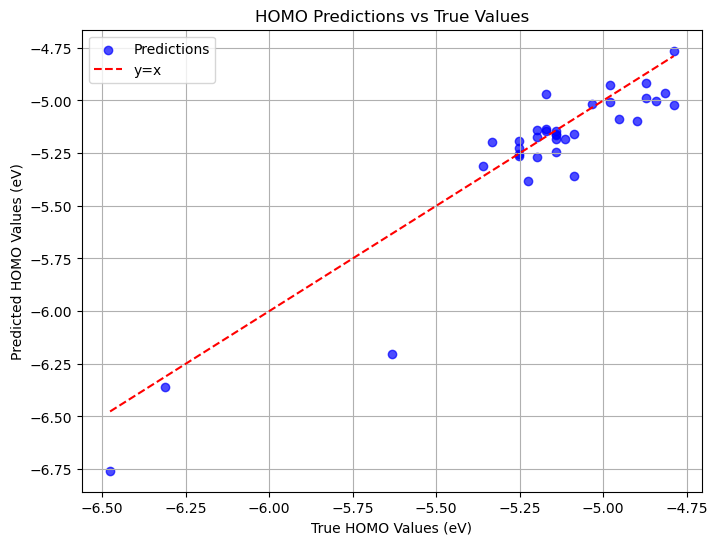

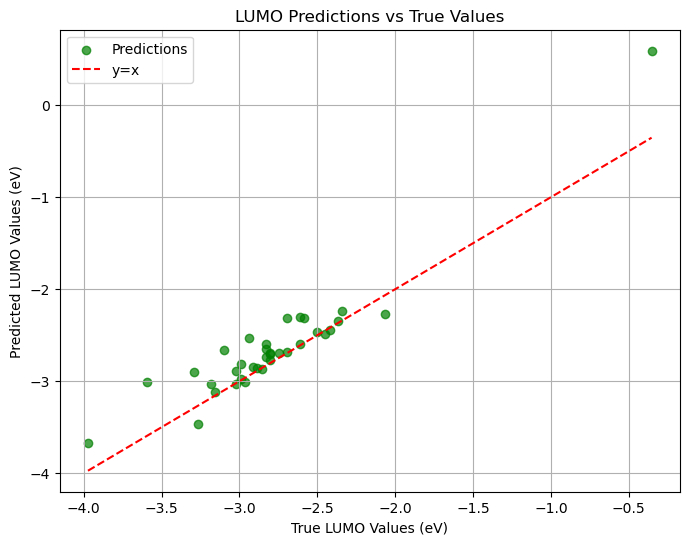

In [11]:
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import global_mean_pool

# Get predictions
predictions = []
true_values = []

for batch in eval_loader:
    true_values.append(batch.y.unsqueeze(0))  # Ensure correct shape
    with torch.no_grad():
        val_out = model(pos=batch.pos.to(device), z=batch.z.to(device),
                                batch=batch.batch.to(device))
        val_graph_out = global_mean_pool(val_out, batch.batch)  # Shape: [batch_size, d]
        predictions.append(val_graph_out)

# Convert lists of tensors to a single tensor
true_values = torch.cat(true_values, dim=0).cpu()  # Now shape [num_samples, 2]
predictions = torch.cat(predictions, dim=0).cpu()  # Now shape [num_samples, 2]

# Separate HOMO and LUMO values
true_homo_values = true_values[:, 0]  # Convert to eV
true_lumo_values = true_values[:, 1]  # Convert to eV
predictions_homo_values = predictions[:, 0] 
predictions_lumo_values = predictions[:, 1] 

# 🔵 Plot HOMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_homo_values, predictions_homo_values, c='blue', alpha=0.7, label='Predictions')
plt.plot([min(true_homo_values), max(true_homo_values)], [min(true_homo_values), max(true_homo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True HOMO Values (eV)')
plt.ylabel('Predicted HOMO Values (eV)')
plt.title('HOMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("SolarTab_homo_prediction.png")

# 🟢 Plot LUMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_lumo_values, predictions_lumo_values, c='green', alpha=0.7, label='Predictions')
plt.plot([min(true_lumo_values), max(true_lumo_values)], [min(true_lumo_values), max(true_lumo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True LUMO Values (eV)')
plt.ylabel('Predicted LUMO Values (eV)')
plt.title('LUMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("SolarTab_lumo_prediction.png")


In [5]:
device = torch.device("cpu")
print(f"Device is {device}")

'''After loading the dataset, we train a model using NPA charge as an example.
 	Firstly, construct an untrained model:'''
model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=device)

model.to(device)
params='trained_param/homo_lumo_HarvardOPV.pth'
model.load_state_dict(torch.load(params))
model.eval()

Device is cpu


DetaNet(
  (Radial): Radial_Basis(
    (radial): Bessel_Function()
  )
  (Embedding): Embedding(
    (act): Swish()
    (elec_emb): Linear(in_features=16, out_features=128, bias=False)
    (nuclare_emb): Embedding(35, 128)
    (ls): Linear(in_features=128, out_features=128, bias=True)
  )
  (blocks): Sequential(
    (0): Interaction_Block(
      (message): Message(
        (Attention): Edge_Attention(
          (actq): Swish()
          (actk): Swish()
          (actv): Swish()
          (acta): Swish()
          (softmax): Softmax(dim=-1)
          (lq): Linear(in_features=128, out_features=128, bias=True)
          (lk): Linear(in_features=128, out_features=128, bias=True)
          (lv): Linear(in_features=128, out_features=256, bias=True)
          (la): Linear(in_features=256, out_features=256, bias=True)
          (lrbf): Linear(in_features=32, out_features=128, bias=False)
          (lkrbf): Linear(in_features=128, out_features=128, bias=False)
          (lvrbf): Linear(in_featu

In [6]:
eval_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)


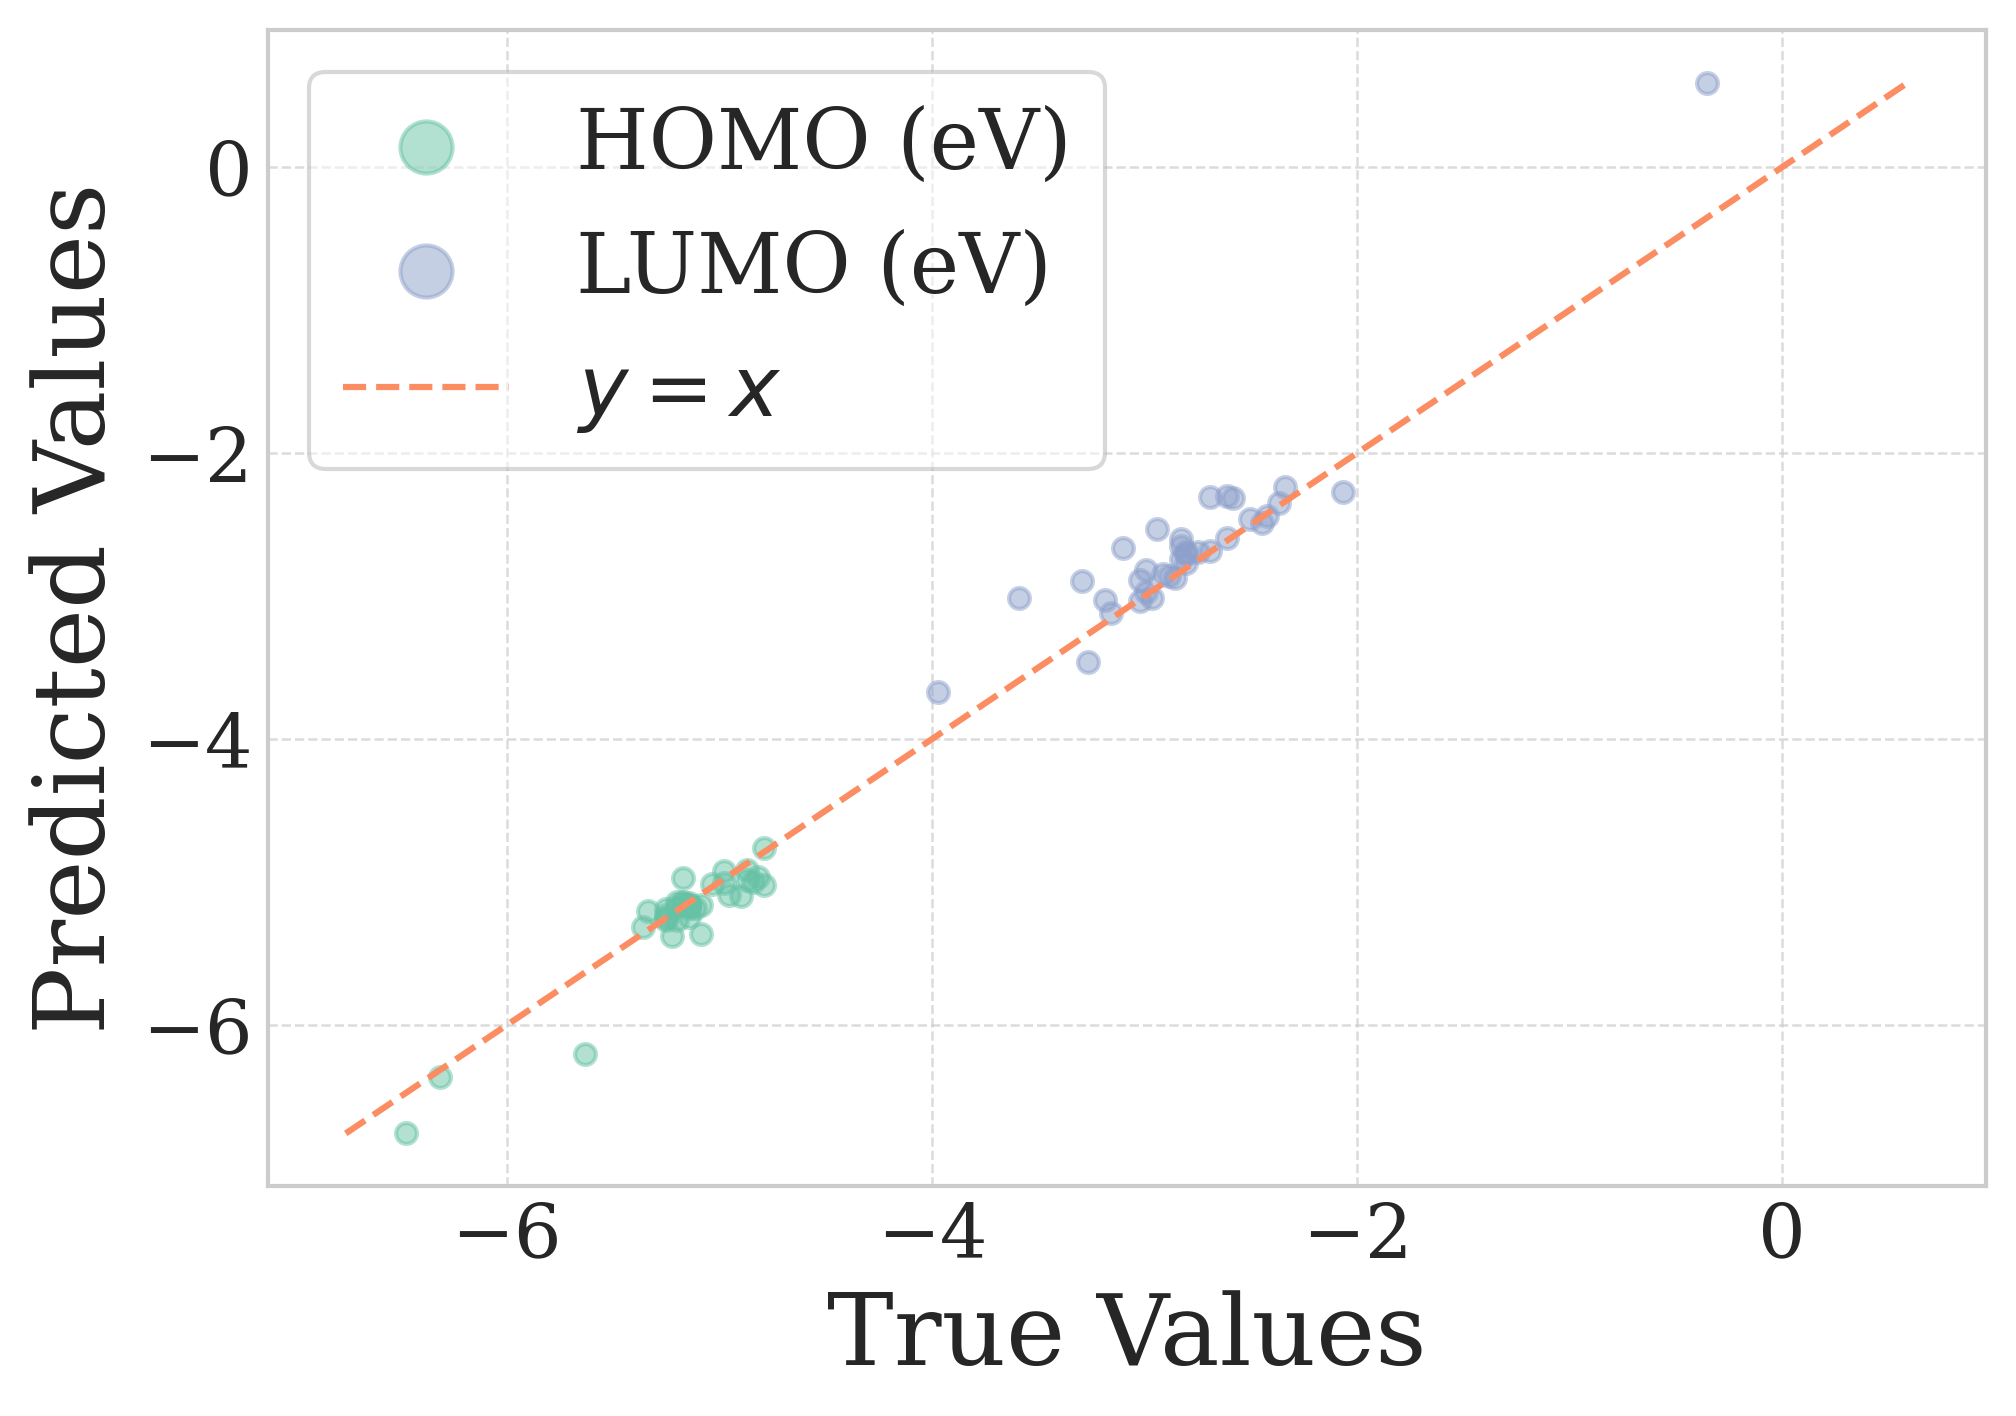

In [7]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.nn import global_mean_pool

# ─────────────────────────────────────────────
# Font and style settings
# ─────────────────────────────────────────────
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.serif":  ["Times New Roman", "Times", "DejaVu Serif", "Georgia"],
    "font.size":        16,
    "axes.labelsize":   24,
    "axes.titlesize":   18,
    "xtick.labelsize":  18,
    "ytick.labelsize":  18,
    "legend.fontsize":  20,
})

# ─────────────────────────────────────────────
# Prediction loop (if not already run)
# ─────────────────────────────────────────────
predictions, true_values = [], []

for batch in eval_loader:
    true_values.append(batch.y.unsqueeze(0))  # [1, 2]
    with torch.no_grad():
        val_out = model(pos=batch.pos.to(device),
                        z=batch.z.to(device),
                        batch=batch.batch.to(device))
        val_graph_out = global_mean_pool(val_out, batch.batch)  # [1, 2]
        predictions.append(val_graph_out)

true_values = torch.cat(true_values, dim=0).cpu()
predictions = torch.cat(predictions, dim=0).cpu()

# Separate HOMO and LUMO
true_homo_values       = true_values[:, 0]
true_lumo_values       = true_values[:, 1]
pred_homo_values       = predictions[:, 0]
pred_lumo_values       = predictions[:, 1]

# ─────────────────────────────────────────────
# Scatter plot
# ─────────────────────────────────────────────
plt.figure(figsize=(7, 5), dpi=300)

plt.scatter(true_homo_values, pred_homo_values,
            c="#66c2a5", alpha=0.5, s=25, label="HOMO (eV)")
plt.scatter(true_lumo_values, pred_lumo_values,
            c="#8da0cb", alpha=0.5, s=25, label="LUMO (eV)")

vmin = min(true_values.min(), predictions.min())
vmax = max(true_values.max(), predictions.max())
plt.plot([vmin, vmax], [vmin, vmax], ls="--", color="#fc8d62", lw=1.5, label="$y = x$")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
#plt.title("HOMO and LUMO Predictions vs True Values")

plt.legend(
    frameon=True,
    facecolor="white",
    edgecolor="0.7",
    framealpha=0.5,
    markerscale=2.5
)
plt.grid(True, ls="--", lw=0.6, alpha=0.7)
plt.tight_layout()
plt.savefig("HOMO_LUMO_QM9_styled.png", bbox_inches="tight")
plt.show()
